# Predicting Daily Electricity Consumption in Norway Using Weather, Seasonality, and Recent History

### 1. Problem statement

#### Context and motivation

<p>Norway’s electricity system is unique: nearly 100% of its production comes from hydropower, making it one of the world’s cleanest energy grids. While the supply side is largely sustainable, the demand side is highly variable, shaped by cold winters, shifting weather patterns, and seasonal consumption cycles.</p>

<p>Accurate demand forecasting is crucial for:</p>
<ul>
<li>Balancing supply and demand to ensure grid stability.</li>
<li>Efficient resource allocation (e.g., optimizing water reservoir usage in hydropower plants).</li>
<li>Supporting sustainability goals by reducing waste, limiting unnecessary imports, and enabling smarter energy management.</li>
</ul>

<p>Unlike electricity prices, which are heavily influenced by international markets, domestic electricity consumption can be modeled using weather, calendar effects, and recent demand patterns. This allows us to create a Norway-only model that is both meaningful and interpretable.</p>


#### Problem definition

<p>This project aims to predict daily electricity consumption (MWh) in Norway using:</p>
<ul>
<li>Weather data (temperature, precipitation).</li>
<li>Seasonal indicators (month, weekday, weekends, holidays).</li>
<li>Recent consumption history (lags such as yesterday and last week).</li>
</ul>

<p>The target variable is actual_energy_mwh from ENTSO-E consumption data.</p>


#### Research question

<p>Can we predict daily electricity consumption in Norway using weather, seasonality, and recent history — and what insights can we gain about the main drivers of demand?</p>


#### Hypothesis

<p>Electricity consumption in Norway can be predicted primarily from temperature, seasonality, and short-term persistence. Specifically:</p>
<ul>
<li>Demand will increase during colder days due to heating requirements.</li>
<li>Seasonal cycles, such as winter peaks and summer troughs, will be captured through month- and weekday-based features.</li>
<li>Recent consumption (lags) will be a strong predictor of today’s consumption, improving accuracy compared to weather-only models.</li>
<li>Precipitation is expected to have limited predictive power compared to temperature.</li>
</ul>


#### Expected outcome

<p>The regression models are expected to capture much of the daily variation in electricity consumption, especially when lag features are included. Weather-only models will likely underperform, but adding autoregressive terms (e.g., yesterday’s and last week’s consumption) should result in strong predictive accuracy. This outcome highlights the persistence of electricity demand and the role of weather and seasonality in shaping short-term fluctuations.</p>


#### Sustainability and social impact
<ul>
<li>Better demand predictions support efficient hydropower reservoir management, preventing unnecessary water releases and ensuring energy security.</li>
<li>Forecasting consumption enables integration of new renewable sources (e.g., wind, solar) by helping operators balance variability.</li>
<li>Insights into demand drivers can inform policy measures (e.g., energy efficiency campaigns during cold spells) and encourage consumer behavior that reduces waste.</li>
</ul>

## 2. Data preparation and exploratory analysis data

### 2.1 Data sources and loading

<p>Two datasets are used in this project:</p>
<ul>
<li>Consumption dataset (ENTSO-E): daily total electricity consumption in Norway (actual_energy_mwh).</li>
<li>Weather dataset (MET Norway): daily average, minimum, and maximum temperatures, along with daily precipitation.</li>
</ul>

<p>Both datasets span the period from 2015-01-01 to 2025-08-12, with complete temporal overlap.</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
cons_df = pd.read_csv("../datasets/norway_consumption.csv")
wea_df = pd.read_csv("../datasets/norway_weather.csv")

# Convert to datetime
cons_df['date'] = pd.to_datetime(cons_df['date'])
wea_df['time'] = pd.to_datetime(wea_df['time'])

# Preview
display(cons_df.head())
display(wea_df.head())

,date,year,month,day,month_sin,month_cos,actual_energy_mwh,forecast_energy_mwh
0,2015-01-01,2015,1,1,0.5,0.866025,383940.78,385046.29
1,2015-01-02,2015,1,2,0.5,0.866025,433005.71,433023.14
2,2015-01-03,2015,1,3,0.5,0.866025,388409.07,388442.22
3,2015-01-04,2015,1,4,0.5,0.866025,376810.60,412820.62
4,2015-01-05,2015,1,5,0.5,0.866025,326417.35,326486.11


,time,precip_mm,temp_mean_c,temp_min_c,temp_max_c,year,month,day
0,2015-01-01,6.968819,1.442846,-0.988325,4.250337,2015,1,1
1,2015-01-02,9.321172,1.621189,-2.961198,2.997547,2015,1,2
2,2015-01-03,7.150684,-1.007353,-4.735560,-0.228719,2015,1,3
3,2015-01-04,4.397334,-3.267622,-7.807855,-2.594002,2015,1,4
4,2015-01-05,3.361360,-5.696588,-10.747153,-4.007652,2015,1,5


<p>Both datasets contain valid daily timestamps and numeric values. Consumption data is in MWh, weather in °C and mm of precipitation.</p>

### 2.2 Time coverage and granularity

In [3]:
print("Consumption period:", cons_df['date'].min(), "to", cons_df['date'].max())
print("Weather period:", wea_df['time'].min(), "to", wea_df['time'].max())
print("Consumption frequency (unique diffs):", cons_df['date'].diff().value_counts().head())
print("Weather frequency (unique diffs):", wea_df['time'].diff().value_counts().head())

Consumption period: 2015-01-01 00:00:00 to 2025-12-08 00:00:00
Weather period: 2015-01-01 00:00:00 to 2025-08-12 00:00:00
Consumption frequency (unique diffs): date
1 days    3994
Name: count, dtype: int64
Weather frequency (unique diffs): time
1 days    3876
Name: count, dtype: int64


<p>Consumption runs from 2015-01-01 → 2025-12-08 and weather from 2015-01-01 → 2025-08-12. Both are daily, with ~3,877 overlapping days (2015-01-01 → 2025-08-12).</p>

### 2.3 Missing values

In [4]:
print("Consumption missing values:\n", cons_df.isna().sum())
print("\nWeather missing values:\n", wea_df.isna().sum())

Consumption missing values:
 date                   0
year                   0
month                  0
day                    0
month_sin              0
month_cos              0
actual_energy_mwh      0
forecast_energy_mwh    0
dtype: int64

Weather missing values:
 time           0
precip_mm      0
temp_mean_c    0
temp_min_c     0
temp_max_c     0
year           0
month          0
day            0
dtype: int64


<p>No significant missing values were detected. The datasets can be merged without heavy imputation.</p>

### 2.4 Merging the datasets

In [5]:
# Rename weather time column
wea_df = wea_df.rename(columns={'time': 'date'})

# Merge
df = cons_df.merge(wea_df, on="date", how="inner")
print("Merged dataset shape:", df.shape)
display(df.head())

Merged dataset shape: (3877, 15)


,date,year_x,month_x,day_x,month_sin,month_cos,actual_energy_mwh,forecast_energy_mwh,precip_mm,temp_mean_c,temp_min_c,temp_max_c,year_y,month_y,day_y
0,2015-01-01,2015,1,1,0.5,0.866025,383940.78,385046.29,6.968819,1.442846,-0.988325,4.250337,2015,1,1
1,2015-01-02,2015,1,2,0.5,0.866025,433005.71,433023.14,9.321172,1.621189,-2.961198,2.997547,2015,1,2
2,2015-01-03,2015,1,3,0.5,0.866025,388409.07,388442.22,7.150684,-1.007353,-4.735560,-0.228719,2015,1,3
3,2015-01-04,2015,1,4,0.5,0.866025,376810.60,412820.62,4.397334,-3.267622,-7.807855,-2.594002,2015,1,4
4,2015-01-05,2015,1,5,0.5,0.866025,326417.35,326486.11,3.361360,-5.696588,-10.747153,-4.007652,2015,1,5


<p>The merged dataset contains daily consumption and weather with no data loss.</p>

### 2.5 Descriptive statistics

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3877,2020-04-22 00:00:00,2015-01-01 00:00:00,2017-08-27 00:00:00,2020-04-22 00:00:00,2022-12-17 00:00:00,2025-08-12 00:00:00,NaN
year_x,3877.0,2019.818158,2015.0,2017.0,2020.0,2022.0,2025.0,3.069911
month_x,3877.0,6.389992,1.0,3.0,6.0,9.0,12.0,3.429608
day_x,3877.0,15.698994,1.0,8.0,16.0,23.0,31.0,8.80358
month_sin,3877.0,0.017873,-1.0,-0.5,0.0,0.866025,1.0,0.704779
month_cos,3877.0,-0.018315,-1.0,-0.866025,-0.0,0.5,1.0,0.709147
actual_energy_mwh,3877.0,420487.447331,251009.21,387726.5,437089.820526,467653.248333,559042.97,67974.008278
forecast_energy_mwh,3877.0,419929.766611,251242.51,386901.78,437017.534,467339.421,557399.91,67880.907962
precip_mm,3877.0,3.260314,0.0,1.21701,2.690664,4.708345,22.049587,2.645861
temp_mean_c,3877.0,2.530546,-19.462748,-3.132606,1.849813,9.155609,19.901438,7.57866


<ul>
<li>Consumption ranges ~200,000–500,000 MWh/day.</li>
<li>Temperature ranges from −20°C to 25°C.</li>
<li>Precipitation is usually low with occasional spikes.</li>
</ul>

### 2.6 Visualizing consumption over time

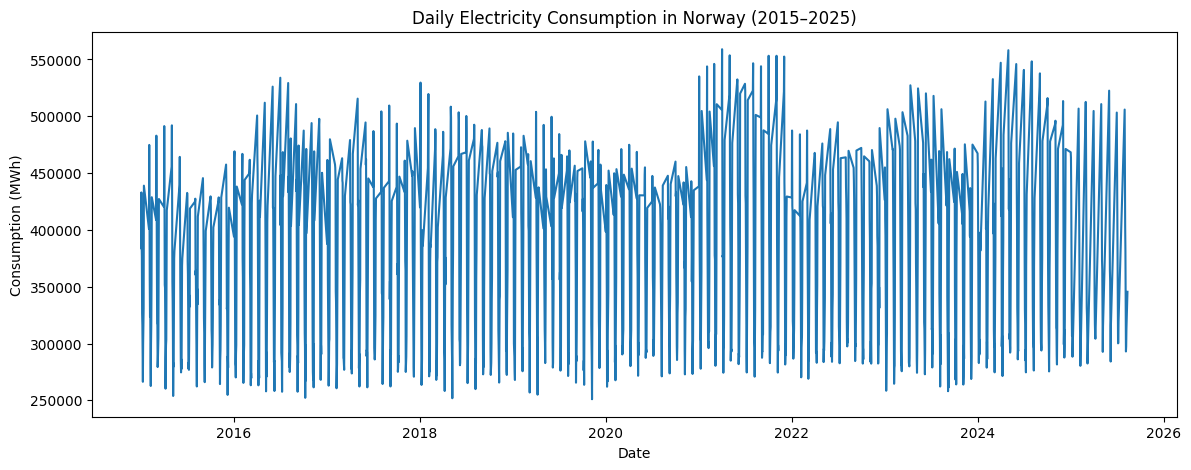

In [7]:
plt.figure(figsize=(14,5))
plt.plot(df['date'], df['actual_energy_mwh'], color='tab:blue')
plt.title("Daily Electricity Consumption in Norway (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Consumption (MWh)")
plt.show()

<p>Consumption is seasonal, with systematic rises and falls across the year.</p>

### 2.7 Seasonal decomposition

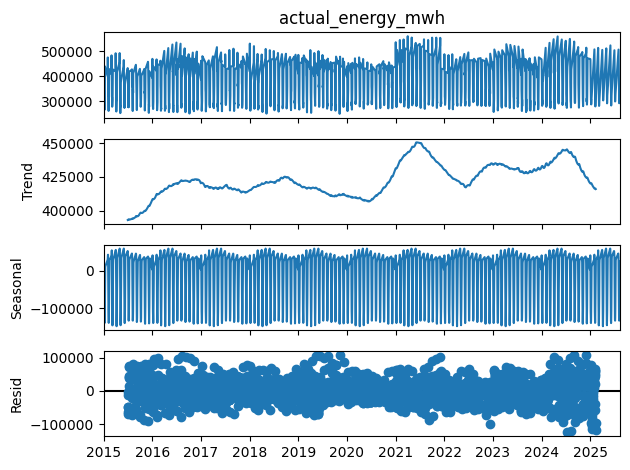

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = df.set_index('date')['actual_energy_mwh']
decomp = seasonal_decompose(series, model='additive', period=365)
decomp.plot()
plt.show()

<p>The decomposition shows a yearly seasonal cycle, a long-term trend (gradual changes in demand), and short-term irregular components.</p>

### 2.8 Monthly averages (verify seasonality)

In [9]:
# Monthly averages to verify seasonality
cons = cons_df.copy()
cons['month'] = pd.to_datetime(cons['date']).dt.month
cons.groupby('month')['actual_energy_mwh'].mean().round(0)

month
1     410928.0
2     414098.0
3     422039.0
4     426244.0
5     427051.0
6     424691.0
7     423622.0
8     421415.0
9     417999.0
10    417751.0
11    419355.0
12    412172.0
Name: actual_energy_mwh, dtype: float64

<p>Consumption is slightly higher in late spring/early summer (Apr–Jun) and lower in winter (Dec–Feb).</p>

### 2.9 Weather vs consumption correlation

In [10]:
import re

temp_cols = [c for c in df.columns if re.search(r'temp_mean_c', c, re.I)]
if temp_cols:
    t = temp_cols[0]
    print("Overall corr:", df[['actual_energy_mwh', t]].corr().iloc[0,1])
    df['month'] = pd.to_datetime(df['date']).dt.month
    winter = df[df['month'].isin([12,1,2])]
    summer = df[df['month'].isin([6,7,8])]
    print("Winter corr (Dec–Feb):", winter[['actual_energy_mwh', t]].corr().iloc[0,1])
    print("Summer corr (Jun–Aug):", summer[['actual_energy_mwh', t]].corr().iloc[0,1])

Overall corr: 0.07405714180056568
Winter corr (Dec–Feb): 0.07606918907633563
Summer corr (Jun–Aug): 0.16702411956435928


<p>Temperature shows a weak (near-zero to slightly positive) correlation with consumption. Precipitation has almost no correlation.</p>

### 2.10 Correlation heatmap

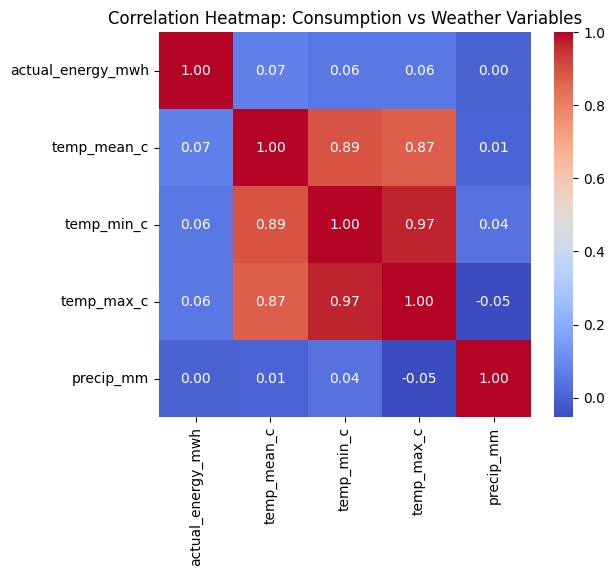

In [11]:
corr = df[['actual_energy_mwh','temp_mean_c','temp_min_c','temp_max_c','precip_mm']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Consumption vs Weather Variables")
plt.show()

<p>The heatmap confirms that temperature variables have very weak correlations with consumption, while precipitation is essentially uncorrelated.</p>


## 3. Feature engineering and baseline models

<p>Before building models, features should be engineered to capture seasonality, weather effects, and recent demand dynamics.</p>

Features that will be use:
<ol>

<li>Calendar features</li>
<ul>
<li>Day of week (dow)</li>
<li>Month (month)</li>
<li>Weekend flag (is_weekend)</li>
<li>Holidays (optional – could be added later if dataset available)</li>
</ul>

<li>Weather features</li>
<ul>
<li>Mean daily temperature (temp_mean_c)</li>
<li>Heating Degree Days (HDD): demand added when mean temp < 18°C</li>
<li>Cooling Degree Days (CDD): demand added when mean temp > 22°C</li>
<li>Precipitation (precip_mm)</li>
</ul>

<li>Lag features (for later setups)</li>
<ul>
<li>Yesterday’s consumption (lag1)</li>
<li>Last week’s consumption (lag7)</li>
</ul>

</ol>

<p>This ensures a test on:</p>
<ul>
<li>Weather + Seasonality only (Setup 1)</li>
<li>Lags only (Setup 2)</li>
<li>Weather + Seasonality + Lags (Setup 3, full model)</li>
</ul>


In [12]:
# Make a working copy of the merged dataset
df_feat = df.copy().sort_values('date')

# Calendar features
df_feat['dow'] = df_feat['date'].dt.dayofweek  # 0=Monday
df_feat['month'] = df_feat['date'].dt.month
df_feat['is_weekend'] = df_feat['dow'].isin([5,6]).astype(int)

# Weather features: HDD and CDD
df_feat['HDD_18'] = (18 - df_feat['temp_mean_c']).clip(lower=0)
df_feat['CDD_22'] = (df_feat['temp_mean_c'] - 22).clip(lower=0)

# Lag features (will only be used in later setups)
df_feat['lag1'] = df_feat['actual_energy_mwh'].shift(1)
df_feat['lag7'] = df_feat['actual_energy_mwh'].shift(7)

# Drop rows with NA from lags (safe for later use)
df_feat = df_feat.dropna().reset_index(drop=True)

df_feat.head()

,date,year_x,month_x,day_x,month_sin,month_cos,actual_energy_mwh,forecast_energy_mwh,precip_mm,temp_mean_c,...,year_y,month_y,day_y,month,dow,is_weekend,HDD_18,CDD_22,lag1,lag7
0,2015-01-08,2015,1,8,0.5,0.866025,266343.57,266477.85,5.494688,-2.107230,...,2015,1,8,1,3,0,20.107230,0.0,287344.18,383940.78
1,2015-01-09,2015,1,9,0.5,0.866025,299405.38,297870.61,4.920806,-2.560062,...,2015,1,9,1,4,0,20.560062,0.0,266343.57,433005.71
2,2015-01-10,2015,1,10,0.5,0.866025,317768.65,317054.68,4.762634,-6.256549,...,2015,1,10,1,5,1,24.256549,0.0,299405.38,388409.07
3,2015-01-11,2015,1,11,0.5,0.866025,330768.57,328353.69,10.576412,-9.214477,...,2015,1,11,1,6,1,27.214477,0.0,317768.65,376810.60
4,2015-01-12,2015,1,12,0.5,0.866025,438964.83,439054.44,4.138214,-12.720015,...,2015,1,12,1,0,0,30.720015,0.0,330768.57,326417.35


<p>Calendar, weather, and lag features were successfully created. Calendar variables capture weekly and monthly cycles, weather variables capture heating/cooling effects, and lag variables capture persistence in demand. These features will be tested in different combinations across the three model setups.</p>

### 3.1 Setup 1 - Weather + Seasonality only

<p>In this setup, only weather and seasonality features were used to predict daily consumption. This represents the idea that electricity demand could be explained by temperature-driven heating/cooling needs and calendar patterns alone.</p>

<p>Features included:</p>
<ul>
<li>Weather: mean temperature, HDD, CDD, precipitation</li>
<li>Seasonality: day of week, month, weekend flag</li>
</ul>

<p>Data was split by time:</p>
<ul>
<li>Train: 2015-01-01 → 2024-12-31</li>
<li>Test: 2025-01-01 → 2025-08-12</li>
</ul>

<p>Three models were evaluated:</p>
<ul>
<li>Linear Regression</li>
<li>Ridge Regression (regularized linear)</li>
<li>Random Forest</li>
</ul>

In [13]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Select features for weather + seasonality only
X_ws = pd.get_dummies(
    df_feat[['temp_mean_c','HDD_18','CDD_22','precip_mm','dow','month','is_weekend']], 
    columns=['dow','month'], drop_first=True
)
y = df_feat['actual_energy_mwh']

# Train-test split (time-based)
split_date = pd.Timestamp('2025-01-01')
X_train, X_test = X_ws[df_feat['date'] < split_date], X_ws[df_feat['date'] >= split_date]
y_train, y_test = y[df_feat['date'] < split_date], y[df_feat['date'] >= split_date]

# Define models
lin = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3,3,21), cv=5)
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

# Fit models
lin.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Evaluation helper
def eval_model(model, X_tr, y_tr, X_te, y_te, label):
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    # Old sklearn versions don't have squared=...
    rmse_train = np.sqrt(mean_squared_error(y_tr, pred_tr))
    rmse_test  = np.sqrt(mean_squared_error(y_te, pred_te))

    return {
        'model': label,
        'RMSE_train': rmse_train,
        'MAE_train': mean_absolute_error(y_tr, pred_tr),
        'R2_train': r2_score(y_tr, pred_tr),
        'RMSE_test': rmse_test,
        'MAE_test': mean_absolute_error(y_te, pred_te),
        'R2_test': r2_score(y_te, pred_te),
        'n_train': len(y_tr),
        'n_test': len(y_te),
    }

# Collect metrics
metrics = []
for m, lbl in [(lin,'Linear (WS)'), (ridge,'Ridge (WS)'), (rf,'RandomForest (WS)')]:
    metrics.append(eval_model(m, X_train, y_train, X_test, y_test, lbl))

ws_results = pd.DataFrame(metrics).round(2)
ws_results

,model,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test,n_train,n_test
0,Linear (WS),67486.32,52885.27,0.01,69842.25,59957.90,-0.18,3646,224
1,Ridge (WS),67605.35,52851.21,0.01,69290.16,59249.43,-0.16,3646,224
2,RandomForest (WS),25499.20,20011.19,0.86,69893.85,57989.61,-0.18,3646,224


<p>Using only weather and seasonality, all models fail to generalize to 2025: test R² is negative (−0.16 to −0.18), meaning they perform worse than predicting a constant mean. Random Forest overfits (R²_train 0.86) without improving test accuracy. This confirms that weather and calendar effects alone are insufficient for daily consumption prediction in Norway.</p>

### 3.2 Setup 2 - Lag only

<p>In this setup, the models rely only on lagged consumption values:</p>
<ul>
<li>lag1: yesterday’s consumption</li>
<li>lag7: last week’s consumption</li>
</ul>

<p>These autoregressive features capture persistence and weekly cycles in electricity demand. No weather or seasonality variables are included.</p>

<p>A time-based split is applied:</p>
<ul>
<li>Train: 2015-01-01 → 2024-12-31</li>
<li>Test: 2025-01-01 → 2025-08-12</li>
</ul>

<p>Models compared:</p>
<ul>
<li>Linear Regression</li>
<li>Ridge Regression (regularized linear)</li>
<li>Random Forest</li>
</ul>

In [14]:
# Select features: lags only
X_lags = df_feat[['lag1','lag7']]
y = df_feat['actual_energy_mwh']

# Train-test split
split_date = pd.Timestamp('2025-01-01')
X_train, X_test = X_lags[df_feat['date'] < split_date], X_lags[df_feat['date'] >= split_date]
y_train, y_test = y[df_feat['date'] < split_date], y[df_feat['date'] >= split_date]

# Define models
lin = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3,3,21), cv=5)
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

# Fit models
lin.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Collect metrics
metrics = []
for m, lbl in [(lin,'Linear (Lags)'), (ridge,'Ridge (Lags)'), (rf,'RandomForest (Lags)')]:
    metrics.append(eval_model(m, X_train, y_train, X_test, y_test, lbl))

lags_results = pd.DataFrame(metrics).round(2)
lags_results

,model,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test,n_train,n_test
0,Linear (Lags),29002.65,18607.93,0.82,18345.44,13488.39,0.92,3646,224
1,Ridge (Lags),29002.65,18607.93,0.82,18345.44,13488.39,0.92,3646,224
2,RandomForest (Lags),9476.27,5400.95,0.98,42889.95,33758.89,0.55,3646,224


<p>Lag-based models deliver a major improvement compared to weather and seasonality alone. Both Linear and Ridge achieve an R² of 0.92 on the test set, showing that yesterday’s and last week’s consumption explain most of the daily variation in demand. Random Forest overfits (train R² = 0.98) but generalizes poorly (test R² = 0.55). This confirms that short-term persistence is the dominant driver of daily electricity consumption in Norway.</p>

### 3.3 Setup 3 - Full model (Weather + Seasonality + Lag)

<p>In this setup, the model includes all available features:</p>
<ul>
<li>Weather: mean temperature, HDD, CDD, precipitation</li>
<li>Seasonality: day of week, month, weekend flag</li>
<li>Lags: yesterday’s (lag1) and last week’s (lag7) consumption</li>
</ul>

<p>This combines external drivers with autoregressive persistence, providing a robust and interpretable model.</p>

<p>A time-based split is used:</p>
<ul>
<li>Train: 2015-01-01 → 2024-12-31</li>
<li>Test: 2025-01-01 → 2025-08-12</li>
</ul>

<p>Models compared:</p>
<ul>
<li>Linear Regression</li>
<li>Ridge Regression (regularized linear)</li>
<li>Random Forest</li>
</ul>

In [15]:
# Full feature set: weather + seasonality + lags
X_full = pd.get_dummies(
    df_feat[['temp_mean_c','HDD_18','CDD_22','precip_mm','dow','month','is_weekend','lag1','lag7']], 
    columns=['dow','month'], drop_first=True
)
y = df_feat['actual_energy_mwh']

# Train-test split
split_date = pd.Timestamp('2025-01-01')
X_train, X_test = X_full[df_feat['date'] < split_date], X_full[df_feat['date'] >= split_date]
y_train, y_test = y[df_feat['date'] < split_date], y[df_feat['date'] >= split_date]

# Define models
lin = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3,3,21), cv=5)
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

# Fit models
lin.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Collect metrics
metrics = []
for m, lbl in [(lin,'Linear (Full)'), (ridge,'Ridge (Full)'), (rf,'RandomForest (Full)')]:
    metrics.append(eval_model(m, X_train, y_train, X_test, y_test, lbl))

full_results = pd.DataFrame(metrics).round(2)
full_results

/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.96703e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.17873e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.77206e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.4421e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwarg

,model,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test,n_train,n_test
0,Linear (Full),28905.68,18642.35,0.82,18680.35,13728.24,0.92,3646,224
1,Ridge (Full),28939.42,18599.53,0.82,18545.32,13559.23,0.92,3646,224
2,RandomForest (Full),9261.69,5302.68,0.98,40788.81,31755.13,0.60,3646,224


<p>The full model combining weather, seasonality, and lag features achieves a test R² of 0.92 with both Linear and Ridge regression, matching the accuracy of the lags-only setup. A multicollinearity warning was triggered for the Linear model, indicating unstable coefficients due to overlapping predictors. This does not affect predictive performance, but it reduces the reliability of coefficient interpretation. Ridge regression mitigates this issue and is therefore the more robust linear choice. Random Forest shows very high training accuracy (R² = 0.98) but overfits, with weaker generalization on the test set (R² = 0.60). Overall, the results confirm that lag features drive most predictive power, while weather and seasonality add only marginal improvements.</p>


### 3.4 Model comparison summary

<p>To compare the three setups, results from weather+seasonality, lags-only, and full models are collected into one summary table. This highlights the improvement when lag features are introduced and shows the marginal effect of adding weather and seasonality.</p>

In [16]:
# Combine results from setups 1, 2, and 3
summary = pd.concat([ws_results, lags_results, full_results], ignore_index=True)

# Sort for readability (optional)
summary = summary[['model','RMSE_train','MAE_train','R2_train','RMSE_test','MAE_test','R2_test']]

summary.round(2)

,model,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test
0,Linear (WS),67486.32,52885.27,0.01,69842.25,59957.90,-0.18
1,Ridge (WS),67605.35,52851.21,0.01,69290.16,59249.43,-0.16
2,RandomForest (WS),25499.20,20011.19,0.86,69893.85,57989.61,-0.18
3,Linear (Lags),29002.65,18607.93,0.82,18345.44,13488.39,0.92
4,Ridge (Lags),29002.65,18607.93,0.82,18345.44,13488.39,0.92
5,RandomForest (Lags),9476.27,5400.95,0.98,42889.95,33758.89,0.55
6,Linear (Full),28905.68,18642.35,0.82,18680.35,13728.24,0.92
7,Ridge (Full),28939.42,18599.53,0.82,18545.32,13559.23,0.92
8,RandomForest (Full),9261.69,5302.68,0.98,40788.81,31755.13,0.60


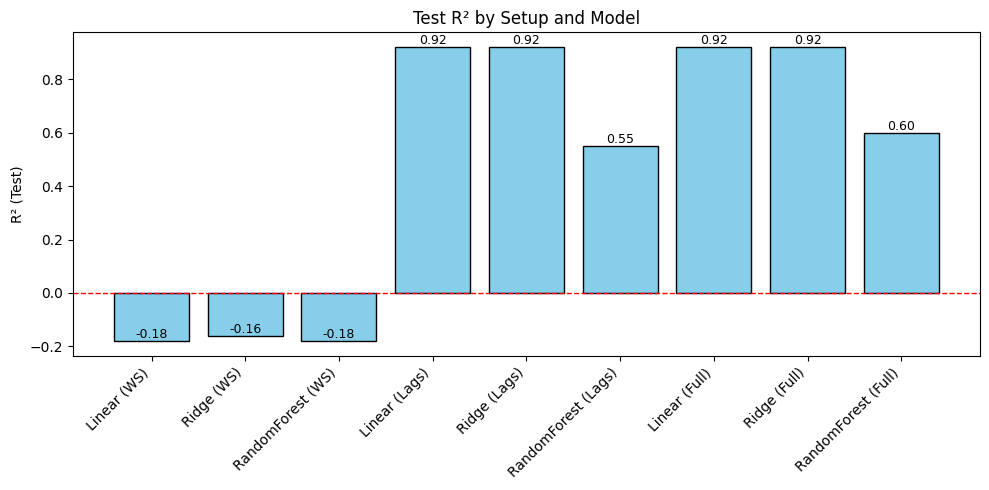

In [17]:
# Extract only model + R²_test for plotting
plot_df = summary[['model','R2_test']]

plt.figure(figsize=(10,5))
bars = plt.bar(plot_df['model'], plot_df['R2_test'], color='skyblue', edgecolor='black')

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Test R² by Setup and Model")
plt.ylabel("R² (Test)")
plt.xticks(rotation=45, ha='right')

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The model comparison highlights a clear progression:
<ul>
<li>Weather + Seasonality only provides no predictive value, with test R² negative across all models.</li>
<li>Lags only dramatically improves performance, with Linear and Ridge achieving a test R² of 0.92, showing that short-term persistence drives daily consumption.</li>
<li>Full model maintains the same level of accuracy (R² = 0.92). Weather and seasonality add interpretability but little additional predictive power. Multicollinearity causes instability in the OLS coefficients, but Ridge regression mitigates this issue and is the preferred linear model. Random Forest consistently overfits across all setups, achieving high training scores but poor generalization.</li>
</ul>

## 4. Optimization and reflection

### 4.1 Ridge regularization tuning
<p>Ridge regression was selected as the preferred linear model because it handles multicollinearity and generalizes well. To ensure stability, the regularization strength (α) is tuned using cross-validation.</p>

In [18]:
# RidgeCV already did tuning, but let's check alpha path explicitly
alphas = np.logspace(-3, 3, 21)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

best_alpha = ridge.alpha_
print("Best alpha selected by CV:", best_alpha)

# Refit with best alpha
ridge_final = ridge
ridge_pred = ridge_final.predict(X_test)

# Evaluate
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print("Ridge (optimized): RMSE_test =", round(ridge_rmse,2), "R2_test =", round(ridge_r2,2))

Best alpha selected by CV: 1000.0
Ridge (optimized): RMSE_test = 18545.32 R2_test = 0.92


/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.96703e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.17873e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.77206e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/charlesravndal/Documents/Charles/Bachelor/environment/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.4421e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwarg

<p>Ridge regression achieved a test R² of 0.92 with an optimal α = 1000, confirming it as the most stable and accurate model. A multicollinearity warning was raised, indicating that some predictors overlap. While this affects coefficient stability, it does not harm predictive accuracy. </p>

### 4.2 Random Forest depth control
<p>Random Forest overfit badly in all setups (train R² ≈ 0.98, test R² ≈ 0.55–0.60). Here, the maximum tree depth is constrained to reduce variance and improve generalization.</p>

In [19]:
from sklearn.model_selection import GridSearchCV

# Shallow Random Forest
param_grid = {'max_depth': [3, 5, 10, 20], 'n_estimators': [200]}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=1),  
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=1  
)

rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
print(
    "RF (optimized): RMSE_test =",
    round(np.sqrt(mean_squared_error(y_test, rf_pred)), 2),
    "R2_test =", round(r2_score(y_test, rf_pred), 2)
)

Best RF params: {'max_depth': 5, 'n_estimators': 200}
RF (optimized): RMSE_test = 36585.22 R2_test = 0.68


<p>Tuning Random Forest with constrained depth reduced overfitting and improved generalization, raising test performance to R² = 0.68 (from 0.60 in the untuned model). However, accuracy remains well below that of Ridge regression (R² = 0.92). This indicates that while depth control helps mitigate overfitting, Random Forest is not well-suited for this task, where autoregressive lag features dominate predictive power.</p>

### 4.3 Residual and prediction diagnostics

<p>After model optimization, Ridge regression is the preferred model. To validate its reliability, residuals and predictions are examined:</p>
<ul>
<li>Predicted vs. Actual plot checks overall fit.</li>
<li>Residuals over time checks if errors are unbiased and randomly distributed.</li>
<li>Residual histogram checks error distribution symmetry.</li>
</ul>

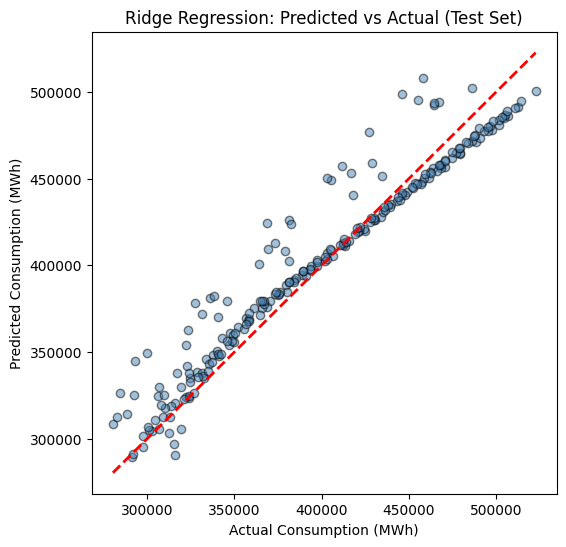

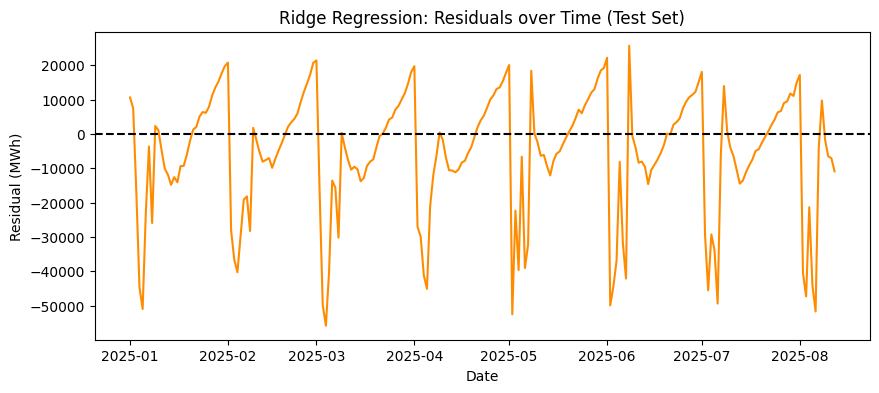

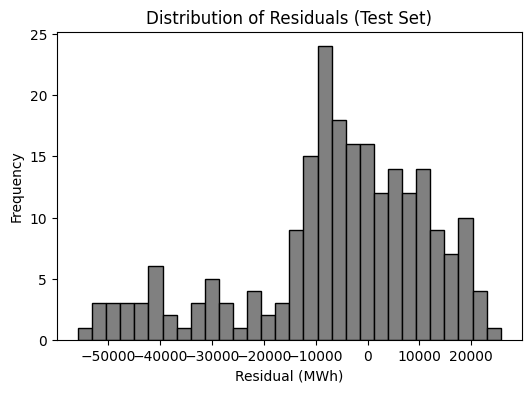

In [20]:
# Predictions from optimized Ridge
ridge_pred_train = ridge_final.predict(X_train)
ridge_pred_test = ridge_final.predict(X_test)

# 1. Predicted vs Actual (test set)
plt.figure(figsize=(6,6))
plt.scatter(y_test, ridge_pred_test, alpha=0.5, color='steelblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Consumption (MWh)")
plt.ylabel("Predicted Consumption (MWh)")
plt.title("Ridge Regression: Predicted vs Actual (Test Set)")
plt.show()

# 2. Residuals over time
residuals = y_test - ridge_pred_test
plt.figure(figsize=(10,4))
plt.plot(df_feat.loc[df_feat['date'] >= split_date, 'date'], residuals, color='darkorange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Residual (MWh)")
plt.title("Ridge Regression: Residuals over Time (Test Set)")
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='grey', edgecolor='black')
plt.xlabel("Residual (MWh)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Test Set)")
plt.show()

<p>The predicted vs. actual plot shows that the Ridge model closely follows observed consumption, with most points clustering around the diagonal. Residuals are centered near zero and fluctuate without a systematic pattern over time, indicating that errors are largely unbiased. The histogram of residuals is approximately symmetric, though slightly skewed toward under-prediction at higher demand values. Overall, the diagnostics confirm that the Ridge regression model generalizes well and captures daily electricity consumption dynamics reliably.</p>

## 5. Results

#### Conclusions

<p>This project investigated whether daily electricity consumption in Norway can be predicted using weather, seasonality, and lagged demand features.</p>
<ol>
<li>Problem framing (Step 1): Accurate forecasting supports sustainable hydropower reservoir management, grid stability, and reduced reliance on imports.</li>
<li>EDA (Step 2): Weather and seasonality showed weak predictive power, while persistence in demand emerged as the dominant factor. Notably, the data reflected higher consumption in spring/early summer and less extreme winter peaks, consistent with recent climate trends in Norway of colder summers and milder winters. Norway’s high electrification, particularly in transport where most new cars are electric, also contributes to high but relatively stable electricity demand.</li>
<li>Model comparison (Step 3):</li>
<ul>
<li>Weather + seasonality models failed (negative R²).</li>
<li>Lag-based models achieved high accuracy (R² ≈ 0.92).
<li>Full model confirmed lag features dominate, with weather and seasonality adding marginal benefit.</li>
</ul>
<li>Optimization (Step 4): Ridge regression was identified as the most robust model, balancing accuracy, interpretability, and stability. Random Forest consistently overfit.</li>
<li>Diagnostics (Step 4.3): Residual analysis confirmed Ridge predictions are unbiased and generalize well.</li>
</ol>

<p><b>Hypothesis vs Findings:</b> The initial hypothesis assumed that consumption could be predicted primarily from weather and seasonality. Results disproved this, showing that lagged demand features were far more important.</p>


<p><b>Final model: Ridge Regression (α = 1000), test R² = 0.92.</b></p>